In [23]:
from op_coreutils.gcpauth import get_credentials
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

import urllib3
import warnings

urllib3.disable_warnings()
warnings.filterwarnings("ignore")

In [24]:
# !uv pip install matplotlib

In [25]:
client = bigquery.Client(credentials=get_credentials())


2024-10-29 16:17:34 [info     ] Loaded 15 items into vault.   
2024-10-29 16:17:34 [info     ] gcpauth.py: vault variable GOOGLE_SERVICE_ACCOUNT is not configured. Will use default auth process.


In [26]:
# query = """
#     SELECT
#         *
#     FROM (
#     SELECT
#         date,
#         chain,
#         COALESCE(md.alignment,'Other') AS alignment,
#         name, 
#         parent_protocol, 
#         category,
#         bd.token,
#         CASE WHEN bd.total_app_tvl < 100000 THEN 'Other' ELSE bd.name END AS name_mapped,
#         CASE WHEN bd.total_app_tvl < 100000 THEN 'Other' ELSE bd.parent_protocol END AS parent_protocol_mapped,
#         CASE WHEN bd.total_app_tvl < 100000 THEN 'Other' ELSE bd.category END AS category_mapped,
#         CASE WHEN bd.usd_value < 10000 THEN 'Other' ELSE bd.token END AS token_mapped,
#         bd.token_value,
#         bd.usd_value,
#         bd.total_app_tvl
#         FROM `oplabs-tools-data.api_table_uploads.daily_defillama_tvl_full_breakdown` bd
#         LEFT JOIN `oplabs-tools-data.api_table_uploads.op_stack_chain_metadata` md
#         ON md.defillama_slug = bd.chain
#     WHERE date >= DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY)
#         AND date <= DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
#         AND token_value > 0
#         AND to_filter_out = 0
#     )
#     WHERE usd_value > 0.1;
# """
# query_job = client.query(query)
# results = query_job.result()
# data = [dict(row) for row in results]
# df = pd.DataFrame(data)


In [27]:
# df.to_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_20240730_to_20241028.csv", index=False)

In [58]:
df = pd.read_csv("/Users/chuck/data/ad_hoc/defillama_tvl_breakdown_20240730_to_20241028.csv")

In [59]:
df["date"] = pd.to_datetime(df["date"])

In [60]:
df_filtered = df[
    (df["date"].dt.time == pd.Timestamp("00:00:00").time())
    &
    (df.alignment.isin(["OP Chain", "OP Stack Fork"])
    | df.chain.isin(["Arbitrum", "Solana", "Polygon", "Avalanche", "Sui"]))
]


In [61]:
df_filtered["parent_protocol"] = df_filtered["parent_protocol"].str.replace("parent#", "")


In [62]:
df_tvl = (
    df_filtered[["date", "chain", "parent_protocol", "usd_value"]]
    .groupby(["date", "chain", "parent_protocol"])
    .sum()
    .reset_index()
)

df_tvl["total_app_tvl_7d_avg"] = (
    df_tvl.groupby(["chain", "parent_protocol"])["usd_value"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

df_tvl["rank"] = df_tvl.groupby(["date", "chain"])["total_app_tvl_7d_avg"].rank(
    method="dense", ascending=False
)

df_tvl_filtered = df_tvl[df_tvl["rank"] <= 10].reset_index(drop=True)


In [63]:
def plot_tvl_over_time(df, chain_name):
    """
    Plots the Total TVL over time for the top apps on a specified blockchain chain.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'date', 'chain', 'parent_protocol', and 'total_app_tvl'.
        chain_name (str): The name of the chain to filter for (e.g., 'Base').

    Returns:
        None: Displays a line plot.
    """
    # Filter the DataFrame for the specified chain
    df_chain = df[df["chain"] == chain_name]

    # Check if there is data for the specified chain
    if df_chain.empty:
        print(f"No data available for chain: {chain_name}")
        return

    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Plot each app's TVL over time
    for app in df_chain["parent_protocol"].unique():
        app_data = df_chain[df_chain["parent_protocol"] == app]
        plt.plot(app_data["date"], app_data["usd_value"], label=app)

    # Add title, labels, and legend
    plt.title(f"Top Apps' Total TVL Over Time for '{chain_name}' Chain")
    plt.xlabel("Date")
    plt.ylabel("Total TVL")
    plt.legend(title="Parent Protocol", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Display the plot
    plt.tight_layout()
    plt.show()

In [64]:
df_tvl_filtered[
    (df_tvl_filtered.chain == "Base")
    & (df_tvl_filtered.parent_protocol == "aerodrome")
    & (df_tvl_filtered.date >= "2024-10-15")
 & (df_tvl_filtered.date < "2024-10-18")
]

,date,chain,parent_protocol,usd_value,total_app_tvl_7d_avg,rank
8599,2024-10-15,Base,aerodrome,1.364432e+09,1.250036e+09,1.0
8722,2024-10-16,Base,aerodrome,1.347531e+09,1.270630e+09,1.0
8844,2024-10-17,Base,aerodrome,1.354638e+09,1.293819e+09,1.0


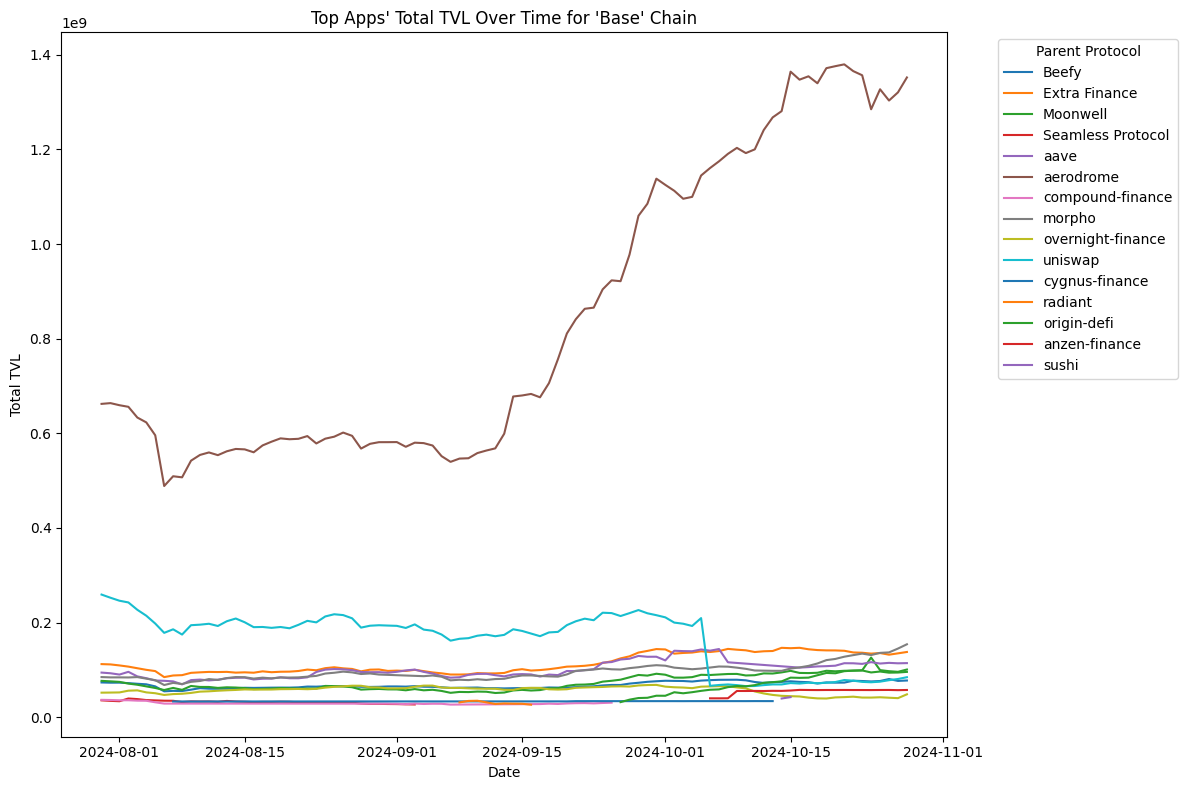

In [65]:
plot_tvl_over_time(df_tvl_filtered, "Base")

In [66]:
df_tvl_filtered[
    (df_tvl_filtered.chain == "Base")
    & (df_tvl_filtered.parent_protocol == "uniswap")
    & (df_tvl_filtered.date >= "2024-10-01")
 & (df_tvl_filtered.date < "2024-10-15")
].da

,date,chain,parent_protocol,usd_value,total_app_tvl_7d_avg,rank
6897,2024-10-01,Base,uniswap,2.110092e+08,2.180471e+08,2.0
7021,2024-10-02,Base,uniswap,1.999304e+08,2.151791e+08,2.0
7145,2024-10-03,Base,uniswap,1.975310e+08,2.128590e+08,2.0
7269,2024-10-04,Base,uniswap,1.928063e+08,2.089856e+08,2.0
7393,2024-10-05,Base,uniswap,2.094328e+08,2.065600e+08,2.0
7517,2024-10-06,Base,uniswap,6.626529e+07,1.846533e+08,2.0
7637,2024-10-07,Base,uniswap,6.804902e+07,1.635749e+08,2.0
7757,2024-10-08,Base,uniswap,6.916476e+07,1.433114e+08,2.0
7878,2024-10-09,Base,uniswap,6.774093e+07,1.244272e+08,3.0
7998,2024-10-10,Base,uniswap,6.560783e+07,1.055810e+08,3.0


In [70]:
df[
    (df.chain == "Base")
    & (df.parent_protocol == "parent#uniswap")
    & (df.date >= "2024-10-10")
 & (df.date < "2024-10-11")
].date.unique()

<DatetimeArray>
['2024-10-10 17:05:23', '2024-10-10 05:11:59', '2024-10-10 00:00:00']
Length: 3, dtype: datetime64[ns]

In [71]:
df["date_trunc"] = df.date.dt.date

<Axes: xlabel='date_trunc'>

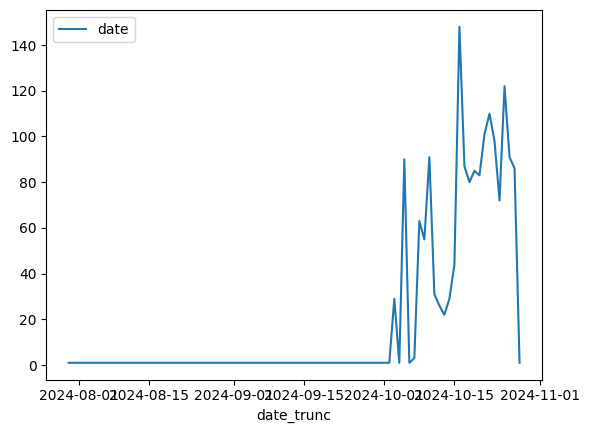

In [73]:
df[["date_trunc", "date"]].groupby("date_trunc").nunique().plot()

In [49]:
df_tvl_filtered[
    (df_tvl_filtered.chain == "Base")
    & (df_tvl_filtered.)
    
    ]

,date,chain,parent_protocol,usd_value,total_app_tvl_7d_avg,rank
26,2024-07-30,Base,Beefy,7.338321e+07,7.338321e+07,7.0
27,2024-07-30,Base,Extra Finance,1.121849e+08,1.121849e+08,3.0
28,2024-07-30,Base,Moonwell,7.676357e+07,7.676357e+07,6.0
29,2024-07-30,Base,Seamless Protocol,3.552998e+07,3.552998e+07,10.0
30,2024-07-30,Base,aave,9.424025e+07,9.424025e+07,4.0
...,...,...,...,...,...,...
10180,2024-10-28,Base,anzen-finance,5.747936e+07,5.738835e+07,9.0
10181,2024-10-28,Base,morpho,1.541031e+08,1.384144e+08,2.0
10182,2024-10-28,Base,origin-defi,9.574901e+07,9.606588e+07,6.0
10183,2024-10-28,Base,overnight-finance,4.831782e+07,4.256632e+07,10.0


In [86]:
df[
    (df.chain == "Base")
    & (df.parent_protocol == "parent#uniswap")
    & (df.date >= "2024-10-10")
 & (df.date < "2024-10-11")
][["date", "chain", "parent_protocol", "name", "total_app_tvl"]].name.unique()

array(['Uniswap V2'], dtype=object)

In [76]:
df

,date,chain,alignment,name,parent_protocol,category,token,name_mapped,parent_protocol_mapped,category_mapped,token_mapped,token_value,usd_value,total_app_tvl,date_trunc
0,2024-10-15 04:50:35,K2,Other,Karak,parent#subseaprotocol,Restaking,ETH,Karak,parent#subseaprotocol,Restaking,ETH,4.321937e+03,1.130662e+07,2.202303e+07,2024-10-15
1,2024-09-13 00:00:00,K2,Other,Karak,parent#subseaprotocol,Restaking,RSWETH,Karak,parent#subseaprotocol,Restaking,RSWETH,2.400698e+03,5.802391e+06,2.292462e+07,2024-09-13
2,2024-08-22 00:00:00,K2,Other,Karak,parent#subseaprotocol,Restaking,USDC,Karak,parent#subseaprotocol,Restaking,USDC,9.458555e+06,9.458555e+06,3.847381e+07,2024-08-22
3,2024-08-29 00:00:00,K2,Other,Karak,parent#subseaprotocol,Restaking,ETH,Karak,parent#subseaprotocol,Restaking,ETH,5.299001e+03,1.340048e+07,2.624097e+07,2024-08-29
4,2024-10-19 00:00:00,K2,Other,Karak,parent#subseaprotocol,Restaking,RSWETH,Karak,parent#subseaprotocol,Restaking,RSWETH,2.040671e+03,5.486670e+06,2.193188e+07,2024-10-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4076709,2024-09-16 00:00:00,Polygon zkEVM,Other,PancakeSwap AMM V3,parent#pancakeswap,Dexes,WETH,PancakeSwap AMM V3,parent#pancakeswap,Dexes,WETH,1.608574e+02,3.794432e+05,7.156791e+05,2024-09-16
4076710,2024-08-25 00:00:00,Polygon zkEVM,Other,PancakeSwap AMM V3,parent#pancakeswap,Dexes,USDC,PancakeSwap AMM V3,parent#pancakeswap,Dexes,USDC,1.166276e+05,1.165903e+05,8.374479e+05,2024-08-25
4076711,2024-10-09 00:00:00,Polygon zkEVM,Other,PancakeSwap AMM V3,parent#pancakeswap,Dexes,WBTC,PancakeSwap AMM V3,parent#pancakeswap,Dexes,Other,4.601000e-02,2.875241e+03,7.042959e+05,2024-10-09
4076712,2024-10-25 05:46:11,Polygon zkEVM,Other,PancakeSwap AMM V3,parent#pancakeswap,Dexes,USDT,PancakeSwap AMM V3,parent#pancakeswap,Dexes,USDT,3.545919e+04,3.544866e+04,4.018526e+05,2024-10-25
